In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

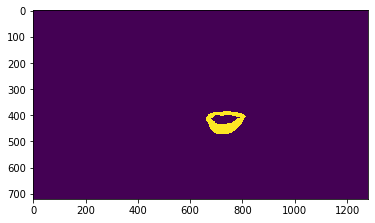

In [4]:
img = plt.imread('/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028594.png')*70
img = np.sum(img, axis=2)
# img = img[..., np.newaxis]
mask_0 = np.where(img <= 50, 0, 255)
mask_1 = np.where(img > 50, 0, 255)
plt.imshow(mask_0)
# plt.imshow(mask_1)


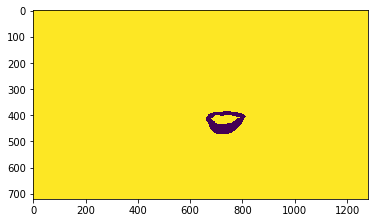

In [5]:
plt.imshow(mask_1)

In [6]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('/home/alex/Downloads/pytorch/set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            cameraRGB.append(f)
        elif 'mask' in f:
            cameraSeg.append(f)
        else:
            break

In [7]:
cameraRGB.sort()
cameraRGB[-10:]

['/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028585.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028586.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028587.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028588.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028589.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028590.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028591.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028592.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028593.jpg',
 '/home/alex/Downloads/pytorch/set-lipstick-original/720p/image00028594.jpg']

In [8]:
cameraSeg.sort()
cameraSeg[-10:]

['/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028585.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028586.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028587.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028588.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028589.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028590.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028591.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028592.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028593.png',
 '/home/alex/Downloads/pytorch/set-lipstick-original/mask/mask00028594.png']

In [12]:
res = {
    'cameraRGB': [],
    'cameraSeg': []
}
for i, mask in enumerate(cameraSeg):
    if mask[-12:-3] in cameraRGB[i]:
        res['cameraRGB'].append(cameraRGB[i])
        res['cameraSeg'].append(mask)
        
len(res)
    

2

In [14]:
df = pd.DataFrame(res)
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                           cameraRGB  \
0  /home/alex/Downloads/pytorch/set-lipstick-orig...   
1  /home/alex/Downloads/pytorch/set-lipstick-orig...   
2  /home/alex/Downloads/pytorch/set-lipstick-orig...   
3  /home/alex/Downloads/pytorch/set-lipstick-orig...   
4  /home/alex/Downloads/pytorch/set-lipstick-orig...   

                                           cameraSeg  
0  /home/alex/Downloads/pytorch/set-lipstick-orig...  
1  /home/alex/Downloads/pytorch/set-lipstick-orig...  
2  /home/alex/Downloads/pytorch/set-lipstick-orig...  
3  /home/alex/Downloads/pytorch/set-lipstick-orig...  
4  /home/alex/Downloads/pytorch/set-lipstick-orig...  


In [15]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [16]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
                
        
        lab = np.asarray(plt.imread(self.label_arr[index]))*70
        
        lab = np.sum(lab, axis=2)
        mask_0 = np.where(lab <= 50, 0, 255)
        mask_1 = np.where(lab > 50, 0, 255)
#         lab = lab[..., np.newaxis]
        
        x_out = torch.as_tensor(mask_0).unsqueeze(0)
        x = torch.as_tensor(mask_1).unsqueeze(0)
        x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        
        # делаем ресайз картинки на 256х256
    
    
    
    
    
    
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [17]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [18]:
train_data_loader = DataLoader(train_data,batch_size=128,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=128,shuffle=False)

In [19]:
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn

import time
from torch.autograd import Variable

from sklearn.metrics import jaccard_similarity_score as jsc

In [20]:
device = torch.device('cpu')

In [21]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score

In [24]:
criterion = SoftDiceLoss()

In [25]:
segmodel = smp.Unet('resnet34', classes=2, activation='softmax', encoder_weights='imagenet').to(device)

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.0001),
])

In [27]:

# создание модели


epoch_losses = []

for epoch in range(2):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss.append(loss.item())
        print(f'batch index : {i} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

batch index : 0 | loss : 0.09054899215698242
batch index : 1 | loss : 0.0639336109161377
batch index : 2 | loss : 0.011448502540588379
batch index : 3 | loss : 0.07838618755340576
batch index : 4 | loss : 0.1072009801864624
batch index : 5 | loss : 0.22757863998413086
batch index : 6 | loss : 0.006922483444213867
batch index : 7 | loss : -0.09055984020233154
batch index : 8 | loss : 0.04954385757446289
batch index : 9 | loss : -0.06556546688079834
batch index : 10 | loss : -0.08113718032836914
batch index : 11 | loss : -0.128798246383667
batch index : 12 | loss : -0.13524222373962402
batch index : 13 | loss : -0.059983015060424805
batch index : 14 | loss : -0.17042672634124756
batch index : 15 | loss : -0.06544756889343262
batch index : 16 | loss : -0.06288838386535645
batch index : 17 | loss : -0.1633998155593872
batch index : 18 | loss : -0.22771966457366943
batch index : 19 | loss : -0.19513440132141113
batch index : 20 | loss : -0.15018141269683838
batch index : 21 | loss : -0.0908

In [28]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

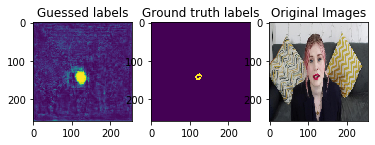

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

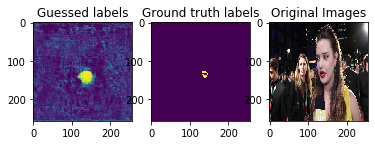

<Figure size 432x288 with 0 Axes>

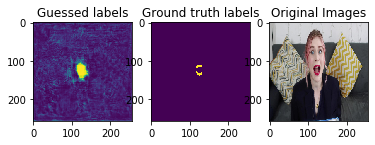

<Figure size 432x288 with 0 Axes>

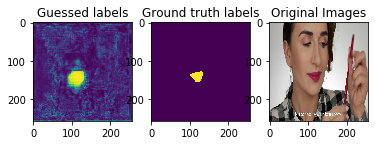

<Figure size 432x288 with 0 Axes>

In [33]:
for i, data in enumerate(train_data_loader):
    images, labels = data
    outputs = segmodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach().cpu().numpy()[0,0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = get_orig(images[0][0,:,:,:])
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>2:
        break